# **Water Management and Forecasting**
### **Project Backgroung**
The arid climate of several Algerian regions and the water-stressed region of Bhopal, effective water management and forecasting are crucial. This project aims to harness the power of machine learning to address the unique water resource challenges faced by both regions. By creating an open-source solution, we aim to empower Algeria and Bhopal to make informed decisions, optimize resource allocation, and build resilient water infrastructure for a sustainable future.
### **Project Goals**
**Develop a Comprehensive Open-Source Water Management and Forecasting System:** Create a user-friendly platform tailored to the specific needs of Algeria and Bhopal, integrating machine learning algorithms for precise water forecasting and efficient water resource management.

- **Enhance Water Resource Utilization:** Improve the sustainable use of water resources in both regions by providing accurate forecasts and real-time monitoring.
- **Capacity Building:** Empower local stakeholders in Algeria and Bhopal with the knowledge and tools necessary to make well-informed decisions about water management.
- **Community Engagement:** Foster collaboration among local government agencies, NGOs, and the research community to collectively address water-related challenges in both regions.

**Data Source:**</BR>
* https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25
* https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V022_CLSM_G025_DA1D

# **Import Modules**

In [3]:
#### Import the libraries needed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

# **Set Environment**

In [4]:
import plotly.io as pio
pio.renderers.default = "vscode"

In [5]:
# Set up directory
working_directory = Path.cwd()
src = working_directory.parents[1]
# data directory
raw_data_directory = src / 'data' / 'raw'
processed_data_directory = src / 'data' / 'processed'
final_data_directory = src / 'data' / 'final'

In [6]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [7]:
# Set default title color
plt.style.use('fivethirtyeight')

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# suptitle
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams['text.color'] = '#333333'
# title
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams['axes.titlecolor'] = '#333333'
# label
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.labelcolor'] = '#333333'
# spines
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# tick
plt.rcParams['xtick.color'] = "#333333"
plt.rcParams['ytick.color'] = "#333333"

## **Load all GFS Datasets and Merge into gfs_df**

* **temperature_2m_above_ground (°C)**: Temperature 2m above ground
* **specific_humidity_2m_above_ground (%)**: Specific humidity 2m above ground
* **relative_humidity_2m_above_ground (%)**: Relative humidity 2m above ground
* **u_component_of_wind_10m_above_ground (m/s)**: U component of wind 10m above ground
* **v_component_of_wind_10m_above_ground (m/s)**: V component of wind 10m above ground
* **total_precipitation_surface (kg/m^2)**: Cumulative precipitation at surface for the previous 1-6 hours, depending on the value of the "forecast_hours" property according to the formula ((F - 1) % 6) + 1 (and only for assets with forecast_hours > 0)
* **precipitable_water_entire_atmosphere (kg/m^2)**: Precipitable water for entire atmosphere
* **total_cloud_cover_entire_atmosphere (%)**: Total cloud cover for entire atmosphere (only for assets with forecast_hours > 0)
* **downward_shortwave_radiation_flux (W/m^2)**: Downward shortwave radiation flux (only for assets with forecast_hours > 0)

In [8]:
# save result in list -> all_filenames
algeria_filenames = [file_name for file_name in glob.glob(str(raw_data_directory) + "/*.csv") if os.path.basename(file_name).startswith('gfs_algeria')]

# Combine all files in the list
gfs_2015_2023_df = pd.concat([pd.read_csv(f) for f in algeria_filenames])

In [9]:
gfs_2015_2023_df['date'] = pd.to_datetime(gfs_2015_2023_df['date'])
gfs_2015_2023_df.sort_values('date', inplace=True)

In [10]:
# Convert the 'date' columns to datetime data type
filenames = os.path.join(raw_data_directory,'GFS_Algiers_2010_2023.csv')
gfs_2010_2023_df = pd.read_csv(filenames)
gfs_2010_2023_df['date'] = pd.to_datetime(gfs_2010_2023_df['date'], format='%y-%m-%d')

In [11]:
# Concat all dataframes
gfs_df = pd.concat([gfs_2010_2023_df, gfs_2015_2023_df])

In [12]:
# Drop unnesesarry columns
gfs_df.drop(['city', 'system:index', '.geo'], axis=1, inplace=True)

In [13]:
gfs_df.head()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
0,2015-04-01,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.000000
1,2015-04-02,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.000000
2,2015-04-03,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.000000
3,2015-04-04,12.117507,0.006628,74.249417,-0.762048,-1.315288,11.899657,0.000000
4,2015-04-05,11.775280,0.006604,75.414558,-1.970064,-1.730378,13.397951,0.015292


In [14]:
gfs_df.tail()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
360,2023-12-27,14.720103,0.005363,50.049523,-1.380142,-0.364674,11.024586,NaN
361,2023-12-28,13.895243,0.005311,52.248889,-1.100965,-0.809100,11.103912,NaN
362,2023-12-29,13.253329,0.005463,55.691171,-1.387969,-0.421550,11.930205,NaN
363,2023-12-30,13.204217,0.005877,59.290021,-1.081521,-0.254748,12.889203,NaN
364,2023-12-31,14.051094,0.006246,59.314265,-1.086104,-0.133382,15.619030,NaN


In [15]:
gfs_df.isna().sum()

date                                       0
temperature_2m_above_ground                0
specific_humidity_2m_above_ground          0
relative_humidity_2m_above_ground          0
u_component_of_wind_10m_above_ground       0
v_component_of_wind_10m_above_ground       0
precipitable_water_entire_atmosphere       0
total_precipitation_surface             2939
dtype: int64

In [16]:
gfs_df.duplicated().sum()

0

## **Load GLDAS Dataset**

* **ACond_tavg (m/s)**: 	Aerodynamic conductance
* **AvgSurfT_tavg (K)**: 	Average surface skin temperature
* **CanopInt_tavg (kg/m^2)**: 	Plant canopy surface water
* **ECanop_tavg (kg/m^2/s)**: 	Canopy water evaporation
* **ESoil_tavg (kg/m^2/s)**: 	Direct evaporation from bare soil
* **Evap_tavg (kg/m^2/s)**: 	Evapotranspiration                 
* **GWS_tavg (mm)**: 	Ground water storage
* **Lwnet_tavg (W/m^2)**: 	Net long-wave radiation flux
* **Qg_tavg (W/m^2)**: 	Heat flux
* **Qh_tavg (W/m^2)**: 	Sensible heat net flux
* **Qle_tavg (W/m^2)**: 	Latent heat net flux
* **Qs_tavg (W/m^2/s)**: 	Storm surface runoff                 
* **SnowT_tavg (K)**: 	Snow Surface temperature
* **SoilMoist_P_tavg (kg/m^2)**: 	Profile Soil moisture
* **SoilMoist_RZ_tavg (kg/m^2)**: 	Root Zone Soil moisture
* **SoilMoist_S_tavg (kg/m^2)**: 	Surface Soil moisture
* **Swnet_tavg (W/m^2)**: 	Net short wave radiation flux
* **TVeg_tavg (kg/m^2/s)**: 	Transpiration               
* **TWS_tavg (mm)**: 	Terrestrial water storage

In [17]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'GLDAS_Algiers_2010_2023.csv')
gldas_df = pd.read_csv(file)
gldas_df['date'] = pd.to_datetime(gldas_df['date'], format='%y-%m-%d')

In [18]:
# Drop the columns that have all 0 values
gldas_df.drop('Qsb_tavg', axis=1, inplace=True)

In [19]:
gldas_df.head()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2010-01-01,Algeirs,0.082993,286.687545,0.017668,6.106833e-06,0.000015,0.0,0.000022,655.390076,-54.342835,-11.430156,-25.461993,53.940294,0.0,1.845114e-06,0.0,286.687545,889.618471,234.228496,5.058322,0.0,71.386511,0.000001,889.636240
1,2010-01-02,Algeirs,0.033933,286.336357,0.013592,2.220712e-06,0.000008,0.0,0.000012,655.785311,-49.610188,-11.082603,4.840276,29.741976,0.0,1.130567e-07,0.0,286.336357,889.981110,234.195734,4.770398,0.0,73.100717,0.000002,889.994643
2,2010-01-03,Algeirs,0.017356,285.944329,0.002365,2.569379e-08,0.000007,0.0,0.000009,656.091261,-65.548131,-5.941080,13.228863,22.964956,0.0,0.000000e+00,0.0,285.944329,889.438253,233.346994,4.729158,0.0,95.803675,0.000003,889.440639
3,2010-01-04,Algeirs,0.019539,288.113141,0.002453,1.132388e-07,0.000011,0.0,0.000014,656.280887,-53.330799,5.021038,-4.210028,34.835989,0.0,1.852611e-08,0.0,288.113141,888.647073,232.366208,4.674092,0.0,88.986264,0.000003,888.649558
4,2010-01-05,Algeirs,0.059151,287.461861,0.020187,4.647594e-06,0.000013,0.0,0.000020,656.415591,-42.786895,-4.772042,-14.750718,49.051028,0.0,1.905058e-06,0.0,287.461861,889.658359,233.242742,5.058011,0.0,72.314331,0.000002,889.678507


In [20]:
gldas_df.tail()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
4924,2023-06-26,Algeirs,0.023664,299.978419,0.000117,6.915491e-10,0.000016,0.0,0.000018,615.131064,-81.450209,3.828643,130.415590,45.406270,0.0,0.000000e+00,0.0,299.978419,817.442170,202.311043,3.753905,0.0,261.102911,0.000002,817.442231
4925,2023-06-27,Algeirs,0.028536,301.610507,0.000080,-9.519874e-11,0.000019,0.0,0.000021,614.274391,-73.203237,11.163433,120.194116,51.941447,0.0,0.000000e+00,0.0,301.610507,815.839382,201.564931,3.695763,0.0,256.507065,0.000002,815.839407
4926,2023-06-28,Algeirs,0.026261,303.132496,0.000303,7.858855e-09,0.000022,0.0,0.000024,613.397566,-83.005846,13.250753,99.281847,59.831149,0.0,1.326372e-11,0.0,303.132496,813.961735,200.564191,3.596900,0.0,255.369908,0.000002,813.962042
4927,2023-06-29,Algeirs,0.018966,302.776263,0.000469,1.130979e-08,0.000017,0.0,0.000018,612.482079,-73.062095,7.882219,126.276936,44.975309,0.0,1.991875e-11,0.0,302.776263,812.211206,199.729207,3.643714,0.0,252.197913,0.000002,812.211777
4928,2023-06-30,Algeirs,0.025112,302.268787,0.000391,5.191073e-09,0.000014,0.0,0.000015,611.545862,-61.037151,4.940081,143.560292,37.948923,0.0,3.829902e-11,0.0,302.268787,810.868841,199.322989,3.703943,0.0,247.484794,0.000001,810.869255


## **Load Algiers-population-2023-11-22.csv**

* **date** 	
* **Population**	 
* **Annual Change**

In [21]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'Algiers-population-2023-11-22.csv')
population_df = pd.read_csv(file)
population_df['date'] = pd.to_datetime(population_df['date'], format='%Y-%m-%d')
population_df.head()

,date,Population,Annual Change
0,1950-12-31,516000,NaN
1,1951-12-31,534000,3.49
2,1952-12-31,552000,3.37
3,1953-12-31,570000,3.26
4,1954-12-31,589000,3.33


In [22]:
population_df.tail()

,date,Population,Annual Change
81,2031-12-31,3312000,1.50
82,2032-12-31,3359000,1.42
83,2033-12-31,3406000,1.40
84,2034-12-31,3451000,1.32
85,2035-12-31,3496000,1.30


## **Descriptive Statistics and Basic Information**

In [23]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3187,2019-08-20 23:19:20.087856896,2015-04-01 00:00:00,2017-06-15 12:00:00,2019-08-21 00:00:00,2021-10-25 12:00:00,2023-12-31 00:00:00,NaN
temperature_2m_above_ground,3187.0,22.332693,6.986266,17.774047,23.455301,26.543987,39.156487,5.846992
specific_humidity_2m_above_ground,3187.0,3.626783,0.001914,0.005813,0.008961,0.016851,92.889523,15.266557
relative_humidity_2m_above_ground,3187.0,52.706236,-3.220027,34.21127,52.665198,73.393865,97.556075,25.487921
u_component_of_wind_10m_above_ground,3187.0,1.968173,-6.547434,-0.657473,0.442289,2.10268,28.931347,5.830683
v_component_of_wind_10m_above_ground,3187.0,3.574357,-3.797217,-0.676354,0.011567,0.73652,92.948071,15.405916
precipitable_water_entire_atmosphere,3187.0,32.312752,3.712291,15.618399,24.764718,51.340212,94.960821,20.590594
total_precipitation_surface,248.0,0.177242,0.0,0.0,0.002996,0.110524,3.637964,0.48427


In [24]:
gldas_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,4929,2016-09-30 00:00:00,2010-01-01 00:00:00,2013-05-17 00:00:00,2016-09-30 00:00:00,2020-02-14 00:00:00,2023-06-30 00:00:00,NaN
ACond_tavg,4929.0,0.027671,0.006431,0.01908,0.024459,0.032703,0.096481,0.012665
AvgSurfT_tavg,4929.0,293.28093,276.692419,287.425346,292.474395,299.394434,309.055053,6.873357
CanopInt_tavg,4929.0,0.013565,0.000014,0.000769,0.00375,0.016614,0.123301,0.021231
ECanop_tavg,4929.0,0.000002,-0.0,0.0,0.0,0.000002,0.000011,0.000002
ESoil_tavg,4929.0,0.000013,0.000003,0.000009,0.000013,0.000016,0.000035,0.000005
EvapSnow_tavg,4929.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
Evap_tavg,4929.0,0.000018,0.000004,0.000012,0.000017,0.000022,0.000064,0.000008
GWS_tavg,4929.0,632.167487,541.784971,591.645508,630.782553,666.914663,736.32852,47.100998
Lwnet_tavg,4929.0,-53.238216,-98.741738,-68.730825,-56.175925,-39.663934,16.565141,20.233416


In [25]:
population_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,86,1993-07-01 05:51:37.674418560,1950-12-31 00:00:00,1972-03-31 12:00:00,1993-07-01 12:00:00,2014-09-30 18:00:00,2035-12-31 00:00:00,NaN
Population,86.0,1936383.72093,516000.0,1334000.0,1883500.0,2551000.0,3496000.0,819776.772608
Annual Change,85.0,2.288941,0.56,1.29,1.68,3.29,7.02,1.618541


In [26]:
# Check the shape of the datasets
print("Shape of datasets")
print("GFS: ", gfs_df.shape)
print("GLADAS: ", gldas_df.shape)
print("Population: ", population_df.shape)

Shape of datasets
GFS:  (3187, 8)
GLADAS:  (4929, 25)
Population:  (86, 3)


In [27]:
# Check the null values
print("Number of null values")
print("GFS: ", gfs_df.isna().sum().sum())
print("GLADAS: ", gldas_df.isna().sum().sum())
print("Population: ", population_df.isna().sum().sum())

Number of null values
GFS:  2939
GLADAS:  0
Population:  1


In [28]:
# Print date range
print("GFS: ", gfs_df['date'].min(), gfs_df['date'].max())
print("GLADS: ", gldas_df['date'].min(), gldas_df['date'].max())
print("Population: ", population_df['date'].min(), population_df['date'].max())

GFS:  2015-04-01 00:00:00 2023-12-31 00:00:00
GLADS:  2010-01-01 00:00:00 2023-06-30 00:00:00
Population:  1950-12-31 00:00:00 2035-12-31 00:00:00


In [29]:
# Check columns
gfs_num_cols = gfs_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gfs_num_cols}")
print()

gfs_cat_cols = gfs_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gfs_cat_cols}")

Numerical Columns: Index(['temperature_2m_above_ground', 'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface'],
      dtype='object')

Categorical Columns: Index(['date'], dtype='object')


In [30]:
# Check columns
gldas_num_cols = gldas_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gldas_num_cols}")
print()
gldas_cat_cols = gldas_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gldas_cat_cols}")

Numerical Columns: Index(['ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'EvapSnow_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg',
       'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qsm_tavg', 'Qs_tavg',
       'SnowDepth_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg', 'SoilMoist_RZ_tavg',
       'SoilMoist_S_tavg', 'SWE_tavg', 'Swnet_tavg', 'TVeg_tavg', 'TWS_tavg'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [31]:
# Check columns
population_num_cols = population_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {population_num_cols}")
print()
population_cat_cols = population_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {population_cat_cols}")

Numerical Columns: Index([' Population', ' Annual Change'], dtype='object')

Categorical Columns: Index(['date'], dtype='object')


## **Merge GLDAS and GFS Datasets**
* GFS_Bhopal_xxxx.csv where xxxx are from 2014 to 2023
* GLDAS_Bhopal_2010_2023.csv

In [53]:
# Merge gldas_df and gfs_df
# gldas_df.drop('city', axis=1, inplace=True)
# gfs_df.drop('city', axis=1, inplace=True)
df = pd.merge(gfs_df, gldas_df, on='date', how='inner')
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2015-04-01,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.0,Algeirs,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155
1,2015-04-02,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.0,Algeirs,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715
2,2015-04-03,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.0,Algeirs,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284


In [54]:
df.tail(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
3000,2023-06-28,25.864821,0.018145,83.699343,2.700613,0.126069,60.577830,NaN,Algeirs,0.026261,303.132496,0.000303,7.858855e-09,0.000022,0.0,0.000024,613.397566,-83.005846,13.250753,99.281847,59.831149,0.0,1.326372e-11,0.0,303.132496,813.961735,200.564191,3.596900,0.0,255.369908,0.000002,813.962042
3001,2023-06-29,26.098176,0.018405,83.348340,3.004154,1.094235,63.986610,NaN,Algeirs,0.018966,302.776263,0.000469,1.130979e-08,0.000017,0.0,0.000018,612.482079,-73.062095,7.882219,126.276936,44.975309,0.0,1.991875e-11,0.0,302.776263,812.211206,199.729207,3.643714,0.0,252.197913,0.000002,812.211777
3002,2023-06-30,25.565309,0.018499,86.207740,3.548710,2.251079,64.801506,NaN,Algeirs,0.025112,302.268787,0.000391,5.191073e-09,0.000014,0.0,0.000015,611.545862,-61.037151,4.940081,143.560292,37.948923,0.0,3.829902e-11,0.0,302.268787,810.868841,199.322989,3.703943,0.0,247.484794,0.000001,810.869255


## **Add population column**
* Add population from Bhopal-population-2023-11-22.csv

In [55]:
# Add the 'population' column to df
population_df['year'] = population_df['date'].dt.year
df['year'] = df['date'].dt.year
df['population'] = [population_df[population_df['year'] == y][' Population'].values[0] for y in df['year']]

In [56]:
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population
0,2015-04-01,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.0,Algeirs,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155,2015,2592000
1,2015-04-02,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.0,Algeirs,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715,2015,2592000
2,2015-04-03,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.0,Algeirs,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284,2015,2592000


# **Descriptive Statistics**

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  3003 non-null   datetime64[ns]
 1   temperature_2m_above_ground           3003 non-null   float64       
 2   specific_humidity_2m_above_ground     3003 non-null   float64       
 3   relative_humidity_2m_above_ground     3003 non-null   float64       
 4   u_component_of_wind_10m_above_ground  3003 non-null   float64       
 5   v_component_of_wind_10m_above_ground  3003 non-null   float64       
 6   precipitable_water_entire_atmosphere  3003 non-null   float64       
 7   total_precipitation_surface           248 non-null    float64       
 8   city                                  3003 non-null   object        
 9   ACond_tavg                            3003 non-null   float64       
 10  

In [58]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,3003,NaN,NaN,NaN,2019-05-20 23:16:50.589410816,2015-04-01 00:00:00,2017-04-30 12:00:00,2019-05-21 00:00:00,2021-06-09 12:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,3003.0,NaN,NaN,NaN,22.390705,6.986266,17.688489,23.494022,26.721665,39.156487,5.934508
specific_humidity_2m_above_ground,3003.0,NaN,NaN,NaN,3.848218,0.001914,0.00573,0.008786,0.0168,92.889523,15.70043
relative_humidity_2m_above_ground,3003.0,NaN,NaN,NaN,51.47189,-3.220027,33.210608,51.276446,71.423869,97.556075,25.435934
u_component_of_wind_10m_above_ground,3003.0,NaN,NaN,NaN,2.043643,-6.547434,-0.637748,0.443573,2.09519,28.931347,5.981154
v_component_of_wind_10m_above_ground,3003.0,NaN,NaN,NaN,3.786554,-3.797217,-0.683871,0.00496,0.739093,92.948071,15.844876
precipitable_water_entire_atmosphere,3003.0,NaN,NaN,NaN,31.999958,3.712291,15.509855,24.530667,50.567387,94.960821,20.622645
total_precipitation_surface,248.0,NaN,NaN,NaN,0.177242,0.0,0.0,0.002996,0.110524,3.637964,0.48427
city,3003,1,Algeirs,3003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACond_tavg,3003.0,NaN,NaN,NaN,0.026656,0.006431,0.018795,0.024148,0.031184,0.091502,0.011706


In [59]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
print(f"First date: {df['date'].min()}")
print(f"Last date: {df['date'].max()}")

First date: 2015-04-01 00:00:00
Last date: 2023-06-30 00:00:00


## **Feature Engineering**
* **Lakes:**
    * Lake Chott Melrhir: 6,700 km²
    * Lake Chott Ech Chergui: 3,000 km²
    * Lake Oubeira: 1,000 km²
    * Lake Fetzara: 400 km²
    * Lake Tonga: 200 km²
    * Lake Mellah: 150 km²
    * Lake El Goléa: 100 km²
    * Lake Télamine: 80 km²
    * Lake Agoulmime: 50 km²
* **Dams and Reservoirs:**
    * Beni Haroun Dam and Reservoir: Reservoir area of 52 km²
    * Ghrib Dam and Reservoir: Reservoir area of 30 km²
    * Taksebt Dam and Reservoir: Reservoir area of 20 km²
    * Koudiat Acerdoune Dam and Reservoir: Reservoir area of 15 km²
    * Boughezoul Dam and Reservoir: Reservoir area of 10 km²
    * Tichy Haf Dam and Reservoir: Reservoir area of 8 km²
    * Oued Fodda Dam and Reservoir: Reservoir area of 6 km²
    * El Kala Dam and Reservoir: Reservoir area of 5 km²
    * El Hamel Dam and Reservoir: Reservoir area of 4 km²
    * Boussiaba Dam and Reservoir: Reservoir area of 3 km²
* 6700 + 3000 + 1000 + 400 + 200 + 150 + 100 + 80 + 50 + 52 + 30 + 20 + 15 + 10 + 8 + 6 + 5 + 4 + 3 = 11833 km²

* The total water surface area of major lakes, dams and reservoirs in Algeria is approximately 5133 km²
* A new feature, 'water_availability' has been created
* 'water_availability' was calculated based on the Algeria's daily water demand per capita: 225 (l/c/d)
$$Daily Water Volume (km^{3})  = 11833 * TWS * 10^{-6} / 365$$
$$Daily Water Volume (Liter)  = Daily Water Volume (km^{3}) * 10^{12}$$
$$Daily Water Demand in Algeria (Liters) = 225 * Population$$
$$Daily Water Availability in Algeria (Liters) = Daily Water Demand in Algeria (Liters) - Daily Water Volume (Liter)$$

###### **Reference**: Wikipedia</br>
###### **URL**: </br>

In [60]:
# Set the total lake and reservoir area to lake_reservoir_area
lake_reservoir_area = 11833

# Domestic use
# min_daily_water_demand_per_capita = 135 
# 225 max add 'max water demand'
daily_water_demand_per_capita = 225

# Calculate daily water volume in liter
daily_water_volume = lake_reservoir_area * (df['TWS_tavg'] * 10**(-6) / 365) * 10**(12)
# min_daily_water_demand = min_daily_water_demand_per_capita * df['population']
# df['min_water_availability'] = daily_water_volume - min_daily_water_demand
daily_water_demand = daily_water_demand_per_capita * df['population']
df['water_availability'] = daily_water_volume - daily_water_demand

In [61]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3003,2019-05-20 23:16:50.589410816,2015-04-01 00:00:00,2017-04-30 12:00:00,2019-05-21 00:00:00,2021-06-09 12:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,3003.0,22.390705,6.986266,17.688489,23.494022,26.721665,39.156487,5.934508
specific_humidity_2m_above_ground,3003.0,3.848218,0.001914,0.00573,0.008786,0.0168,92.889523,15.70043
relative_humidity_2m_above_ground,3003.0,51.47189,-3.220027,33.210608,51.276446,71.423869,97.556075,25.435934
u_component_of_wind_10m_above_ground,3003.0,2.043643,-6.547434,-0.637748,0.443573,2.09519,28.931347,5.981154
v_component_of_wind_10m_above_ground,3003.0,3.786554,-3.797217,-0.683871,0.00496,0.739093,92.948071,15.844876
precipitable_water_entire_atmosphere,3003.0,31.999958,3.712291,15.509855,24.530667,50.567387,94.960821,20.622645
total_precipitation_surface,248.0,0.177242,0.0,0.0,0.002996,0.110524,3.637964,0.48427
ACond_tavg,3003.0,0.026656,0.006431,0.018795,0.024148,0.031184,0.091502,0.011706
AvgSurfT_tavg,3003.0,293.69444,279.48755,287.802589,292.95999,299.650087,309.055053,6.803966


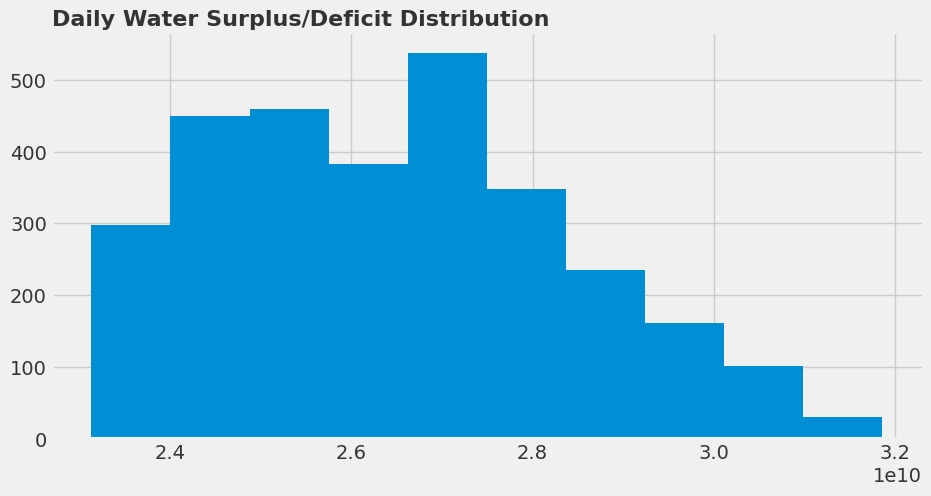

In [62]:
plt.title('Daily Water Surplus/Deficit Distribution')
df['water_availability'].hist();

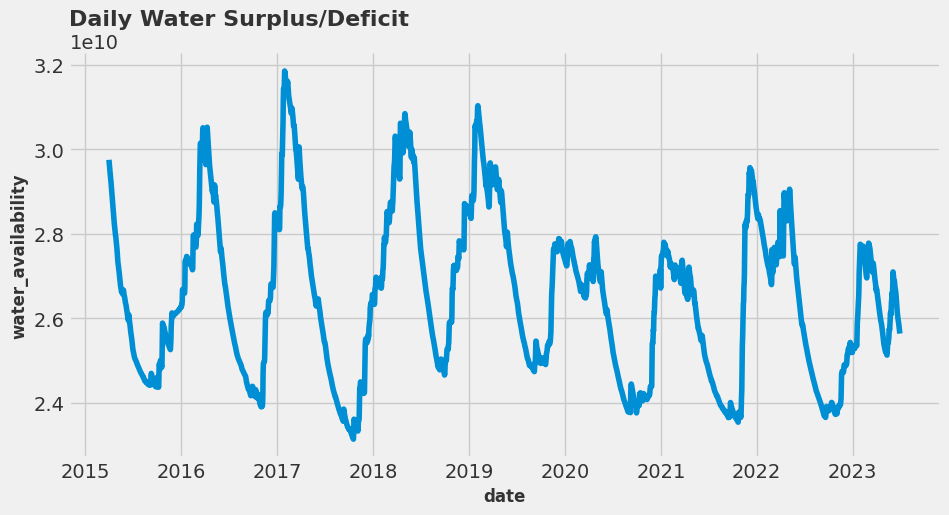

In [63]:
plt.title('Daily Water Surplus/Deficit')
sns.lineplot(x=df['date'], y=df['water_availability']);

In [64]:
# Save the dataframe
file = os.path.join(final_data_directory, "GLDAS_GFS_population_Algeria_2015_2023_final.csv")
df.to_csv(file, index=False, encoding='utf-8-sig')

## **Verify the Merged File**

In [65]:
df = pd.read_csv(file)
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population,water_availability
0,2015-04-01,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.0,Algeirs,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155,2015,2592000,2.975367e+10
1,2015-04-02,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.0,Algeirs,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715,2015,2592000,2.967756e+10
2,2015-04-03,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.0,Algeirs,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284,2015,2592000,2.960597e+10


In [66]:
df.tail(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population,water_availability
3000,2023-06-28,25.864821,0.018145,83.699343,2.700613,0.126069,60.577830,NaN,Algeirs,0.026261,303.132496,0.000303,7.858855e-09,0.000022,0.0,0.000024,613.397566,-83.005846,13.250753,99.281847,59.831149,0.0,1.326372e-11,0.0,303.132496,813.961735,200.564191,3.596900,0.0,255.369908,0.000002,813.962042,2023,2902000,2.573503e+10
3001,2023-06-29,26.098176,0.018405,83.348340,3.004154,1.094235,63.986610,NaN,Algeirs,0.018966,302.776263,0.000469,1.130979e-08,0.000017,0.0,0.000018,612.482079,-73.062095,7.882219,126.276936,44.975309,0.0,1.991875e-11,0.0,302.776263,812.211206,199.729207,3.643714,0.0,252.197913,0.000002,812.211777,2023,2902000,2.567829e+10
3002,2023-06-30,25.565309,0.018499,86.207740,3.548710,2.251079,64.801506,NaN,Algeirs,0.025112,302.268787,0.000391,5.191073e-09,0.000014,0.0,0.000015,611.545862,-61.037151,4.940081,143.560292,37.948923,0.0,3.829902e-11,0.0,302.268787,810.868841,199.322989,3.703943,0.0,247.484794,0.000001,810.869255,2023,2902000,2.563476e+10
